# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise`中，
我们发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。
同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。
本节如在 :numref:`sec_softmax_scratch`中一样，
继续使用Fashion-MNIST数据集，并保持批量大小为256。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l
# import d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax`所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。


In [3]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
# # 输入：假设是 Fashion-MNIST 图像，形状为 [batch_size, 1, 28, 28]
# 输出：展平后的形状 [batch_size, 784]
# 具体转换：
# [64, 1, 28, 28] → [64, 1*28*28] = [64, 784]

# 为什么需要 Flatten？
# 图像数据通常是多维的：[批次, 通道, 高度, 宽度]
# 全连接层 nn.Linear 需要一维输入：[批次, 特征数]
# Flatten() 自动完成这个维度转换

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
# nn.init: PyTorch的初始化模块
# .normal_: 正态分布初始化方法
# 下划线 _ 表示原地操作（in-place operation）
# nn.init.normal_ 方法的完整参数是：torch.nn.init.normal_(tensor, mean=0.0, std=1.0)

net.apply(init_weights)
# 在运行 net.apply(init_weights) 时，传入的 m 是神经网络中的每个子模块
# apply() 方法的工作原理:递归遍历所有模块
# net.apply(init_weights)
# 等价于：
# for module in net.modules():
#     init_weights(module)
# # 第一次调用：m = 整个Sequential容器
# init_weights(net)  # type(m) == nn.Sequential

# # 第二次调用：m = Flatten层  
# init_weights(net[0])  # type(m) == nn.Flatten

# # 第三次调用：m = Linear层
# init_weights(net[1])  # type(m) == nn.Linear

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch`的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [5]:
loss = nn.CrossEntropyLoss(reduction='none')
# nn.CrossEntropyLoss 结合了 Softmax激活 和 交叉熵损失 两个步骤

# # 默认情况（reduction='mean'）
# loss_fn = nn.CrossEntropyLoss()  # 默认reduction='mean'
# loss = loss_fn(input, target)    # 返回标量：批量损失的平均值

# # 使用 reduction='none'
# loss_fn_none = nn.CrossEntropyLoss(reduction='none')
# loss = loss_fn_none(input, target)  # 返回向量：每个样本的单独损失

In [6]:
help(nn.CrossEntropyLoss)

Help on class CrossEntropyLoss in module torch.nn.modules.loss:

class CrossEntropyLoss(_WeightedLoss)
 |  CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None, ignore_index: int = -100, reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None
 |  
 |  This criterion computes the cross entropy loss between input logits
 |  and target.
 |  
 |  It is useful when training a classification problem with `C` classes.
 |  If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
 |  assigning weight to each of the classes.
 |  This is particularly useful when you have an unbalanced training set.
 |  
 |  The `input` is expected to contain the unnormalized logits for each class (which do `not` need
 |  to be positive or sum to 1, in general).
 |  `input` has to be a Tensor of size :math:`(C)` for unbatched input,
 |  :math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
 |  `K`-dimensional cas

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [7]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


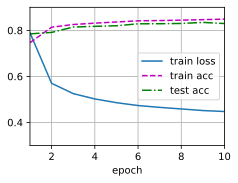

In [8]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [9]:
import d2l
print([attr for attr in dir(d2l.torch) if 'train' in attr.lower()])

['Trainer', 'reorg_train_valid', 'train_2d', 'train_batch_ch13', 'train_ch11', 'train_ch13', 'train_ch3', 'train_ch6', 'train_concise_ch11', 'train_epoch_ch3', 'train_seq2seq']


和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？


[Discussions](https://discuss.d2l.ai/t/1793)
